<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/HW5_prob1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
import torch
import math
import matplotlib.pyplot as plt

In [156]:
torch.manual_seed(0)
dtype = torch.float64

t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0], dtype=dtype)
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4], dtype=dtype)

In [157]:
t_un = 0.1 * t_u

def mse(yhat, y):
    return torch.mean((yhat - y)**2)

In [158]:
def linear_model(t_un, w, b):
    return w * t_un + b

def quadratic_model(t_un, w2, w1, b):
    return w2 * (t_un ** 2) + w1 * t_un + b

In [159]:
def train_linear(lr=0.01, epochs=5000, log_every=500):
    w = torch.ones(1, dtype=dtype, requires_grad=True)
    b = torch.zeros(1, dtype=dtype, requires_grad=True)
    opt = torch.optim.SGD([w, b], lr=lr)

    history = []
    for epoch in range(epochs + 1):
        t_p = linear_model(t_un, w, b)
        loss = mse(t_p, t_c)

        if torch.isnan(loss) or torch.isinf(loss):
            history.append((epoch, float('nan')))
            break

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % log_every == 0:
            history.append((epoch, loss.item()))
            print(f"[Linear]  lr={lr:<7} epoch={epoch:4d}  loss={loss.item():.6f}")
    final_loss = mse(linear_model(t_un, w, b), t_c).item()
    if not history or history[-1][0] != epochs:
        history.append((epochs, final_loss))
    return w.detach(), b.detach(), history, final_loss

def train_quadratic(lr=0.1, epochs=5000, log_every=500):
    w2 = torch.ones(1, dtype=dtype, requires_grad=True)
    w1 = torch.ones(1, dtype=dtype, requires_grad=True)
    b  = torch.zeros(1, dtype=dtype, requires_grad=True)
    opt = torch.optim.SGD([w2, w1, b], lr=lr)

    history = []
    for epoch in range(epochs + 1):
        t_p = quadratic_model(t_un, w2, w1, b)
        loss = mse(t_p, t_c)

        if torch.isnan(loss) or torch.isinf(loss):
            history.append((epoch, float('nan')))
            break

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % log_every == 0:
            history.append((epoch, loss.item()))
            print(f"[Quad]    lr={lr:<7} epoch={epoch:4d}  loss={loss.item():.6f}")
    final_loss = mse(quadratic_model(t_un, w2, w1, b), t_c).item()
    if not history or history[-1][0] != epochs:
        history.append((epochs, final_loss))
    return w2.detach(), w1.detach(), b.detach(), history, final_loss


In [160]:
lrs = [0.1, 0.01, 0.001, 0.0001]

linear_runs = {}
for lr in lrs:
    print("\nTraining using Linear with lr =", lr)
    w, b, hist, fin = train_linear(lr=lr)
    linear_runs[lr] = {"w": w.item(), "b": b.item(), "history": hist, "final_loss": fin}

quad_runs = {}
for lr in lrs:
    print("\nTraining using non linear with lr =", lr)
    w2, w1, b, hist, fin = train_quadratic(lr=lr)
    quad_runs[lr] = {"w2": w2.item(), "w1": w1.item(), "b": b.item(), "history": hist, "final_loss": fin}



Training using Linear with lr = 0.1
[Linear]  lr=0.1     epoch=   0  loss=80.364345

Training using Linear with lr = 0.01
[Linear]  lr=0.01    epoch=   0  loss=80.364345
[Linear]  lr=0.01    epoch= 500  loss=7.843380
[Linear]  lr=0.01    epoch=1000  loss=3.825484
[Linear]  lr=0.01    epoch=1500  loss=3.091632
[Linear]  lr=0.01    epoch=2000  loss=2.957597
[Linear]  lr=0.01    epoch=2500  loss=2.933116
[Linear]  lr=0.01    epoch=3000  loss=2.928645
[Linear]  lr=0.01    epoch=3500  loss=2.927828
[Linear]  lr=0.01    epoch=4000  loss=2.927679
[Linear]  lr=0.01    epoch=4500  loss=2.927652
[Linear]  lr=0.01    epoch=5000  loss=2.927647

Training using Linear with lr = 0.001
[Linear]  lr=0.001   epoch=   0  loss=80.364345
[Linear]  lr=0.001   epoch= 500  loss=25.636552
[Linear]  lr=0.001   epoch=1000  loss=22.088446
[Linear]  lr=0.001   epoch=1500  loss=19.094707
[Linear]  lr=0.001   epoch=2000  loss=16.568718
[Linear]  lr=0.001   epoch=2500  loss=14.437397
[Linear]  lr=0.001   epoch=3000 

In [161]:
#closed form normalization for double check if the model reach to the global minimum
X_lin  = torch.stack([t_un, torch.ones_like(t_un)], dim=1)
X_quad = torch.stack([t_un**2, t_un, torch.ones_like(t_un)], dim=1)

beta_lin  = torch.linalg.lstsq(X_lin,  t_c).solution      # [w, b]
beta_quad = torch.linalg.lstsq(X_quad, t_c).solution      # [w2, w1, b]

mse_lin_cf  = torch.mean((X_lin  @ beta_lin  - t_c)**2).item()
mse_quad_cf = torch.mean((X_quad @ beta_quad - t_c)**2).item()

print("\nClosed-form (normalized):")
print(f"Linear   -> w={beta_lin[0].item():.6f},  b={beta_lin[1].item():.6f},  MSE={mse_lin_cf:.6f}")
print(f"Quadratic-> w2={beta_quad[0].item():.6f}, w1={beta_quad[1].item():.6f}, b={beta_quad[2].item():.6f}, MSE={mse_quad_cf:.6f}")



Closed-form (normalized):
Linear   -> w=5.367719,  b=-17.304786,  MSE=2.927646
Quadratic-> w2=0.283043, w1=2.476041, b=-10.649624, MSE=2.090720


In [162]:
def best_run(run_dict):
    best_lr, best_rec = None, None
    best_loss = float('inf')
    for lr, rec in run_dict.items():
        loss = rec["final_loss"]
        if loss is not None and not math.isnan(loss) and loss < best_loss:
            best_loss = loss
            best_lr, best_rec = lr, rec
    return best_lr, best_rec

best_lr_lin, best_lin = best_run(linear_runs)
best_lr_quad, best_quad = best_run(quad_runs)

print(f"Linear best  -> lr={best_lr_lin},  w={best_lin['w']:.4f}, b={best_lin['b']:.4f},  final MSE={best_lin['final_loss']:.6f}")
print(f"Quadratic best-> lr={best_lr_quad}, w2={best_quad['w2']:.4f}, w1={best_quad['w1']:.4f}, b={best_quad['b']:.4f}, final MSE={best_quad['final_loss']:.6f}")


Linear best  -> lr=0.01,  w=5.3671, b=-17.3012,  final MSE=2.927647
Quadratic best-> lr=0.0001, w2=0.5570, w1=-0.8882, b=-0.8754, final MSE=3.861272


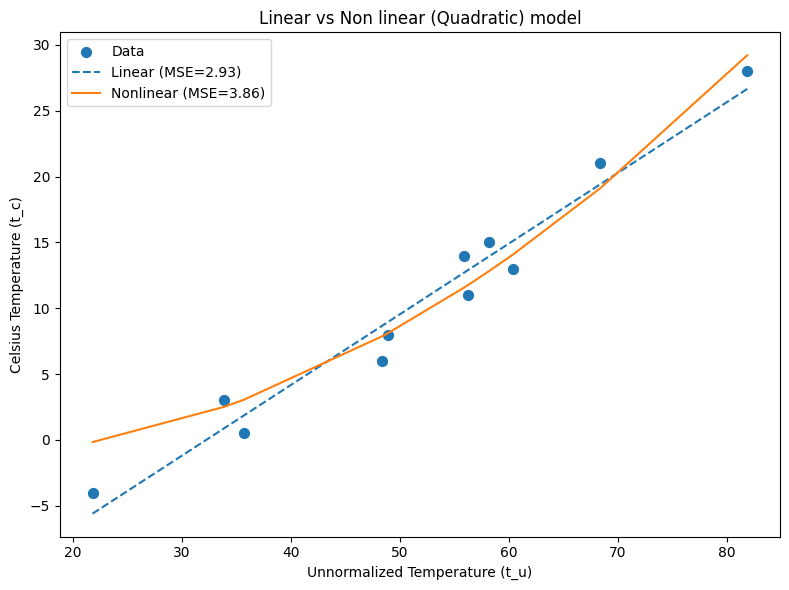

In [163]:
w_lin, b_lin = best_lin["w"], best_lin["b"]
w2_q, w1_q, b_q = best_quad["w2"], best_quad["w1"], best_quad["b"]

with torch.no_grad():
    y_lin  = linear_model(t_un, torch.tensor([w_lin],dtype=dtype),  torch.tensor([b_lin],dtype=dtype))
    y_quad = quadratic_model(t_un, torch.tensor([w2_q], dtype=dtype), torch.tensor([w1_q],dtype=dtype), torch.tensor([b_q],dtype=dtype))

idx = torch.argsort(t_u)
x_sorted        = t_u[idx].numpy()
y_lin_sorted    = y_lin[idx].numpy()
y_quad_sorted   = y_quad[idx].numpy()

plt.figure(figsize=(8,6))
plt.scatter(t_u.numpy(), t_c.numpy(), label="Data", s=50)
plt.plot(x_sorted, y_lin_sorted,  linestyle="--", label=f"Linear (MSE={best_lin['final_loss']:.2f})")
plt.plot(x_sorted, y_quad_sorted,                 label=f"Nonlinear (MSE={best_quad['final_loss']:.2f})")
plt.xlabel("Unnormalized Temperature (t_u)")
plt.ylabel("Celsius Temperature (t_c)")
plt.title("Linear vs Non linear (Quadratic) model")
plt.legend()
plt.tight_layout()
plt.show()


In [164]:
def print_history_table(title, run_dict, epochs=5000, step=500):
    print("\n" + title)
    for lr, rec in sorted(run_dict.items(), key=lambda kv: kv[0]):
        print(f"  LR={lr}:")
        hdict = {ep: ls for (ep, ls) in rec["history"]}
        for ep in range(0, epochs + 1, step):
            if ep in hdict:
                ls = hdict[ep]
                if math.isnan(ls) or math.isinf(ls):
                    print(f"    epoch {ep:4d}  loss=NaN/Inf (diverged)")
                else:
                    print(f"    epoch {ep:4d}  loss={ls:.6f}")
            else:
                print(f"    epoch {ep:4d}  loss=— (diverged before this)")

print_history_table("LINEAR – Loss every 500 epochs", linear_runs)
print_history_table("QUADRATIC – Loss every 500 epochs", quad_runs)


LINEAR – Loss every 500 epochs
  LR=0.0001:
    epoch    0  loss=80.364345
    epoch  500  loss=29.503581
    epoch 1000  loss=28.942883
    epoch 1500  loss=28.504417
    epoch 2000  loss=28.073594
    epoch 2500  loss=27.650028
    epoch 3000  loss=27.233597
    epoch 3500  loss=26.824181
    epoch 4000  loss=26.421661
    epoch 4500  loss=26.025921
    epoch 5000  loss=25.636847
  LR=0.001:
    epoch    0  loss=80.364345
    epoch  500  loss=25.636552
    epoch 1000  loss=22.088446
    epoch 1500  loss=19.094707
    epoch 2000  loss=16.568718
    epoch 2500  loss=14.437397
    epoch 3000  loss=12.639080
    epoch 3500  loss=11.121737
    epoch 4000  loss=9.841468
    epoch 4500  loss=8.761233
    epoch 5000  loss=7.849776
  LR=0.01:
    epoch    0  loss=80.364345
    epoch  500  loss=7.843380
    epoch 1000  loss=3.825484
    epoch 1500  loss=3.091632
    epoch 2000  loss=2.957597
    epoch 2500  loss=2.933116
    epoch 3000  loss=2.928645
    epoch 3500  loss=2.927828
    epoch 40

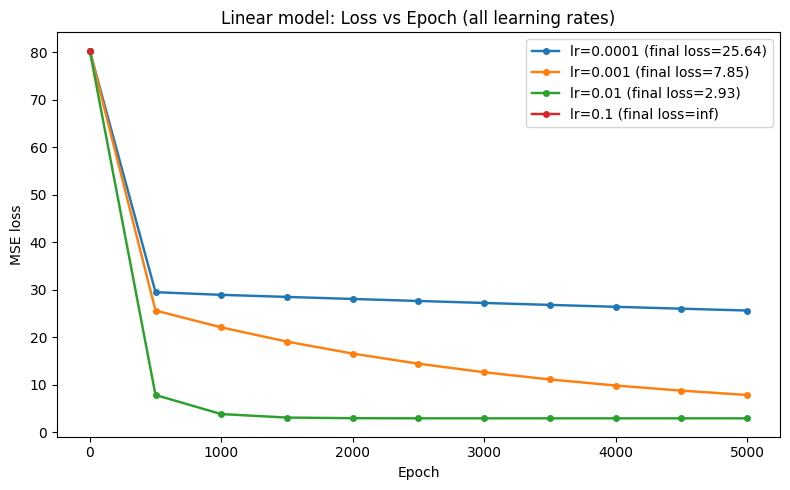

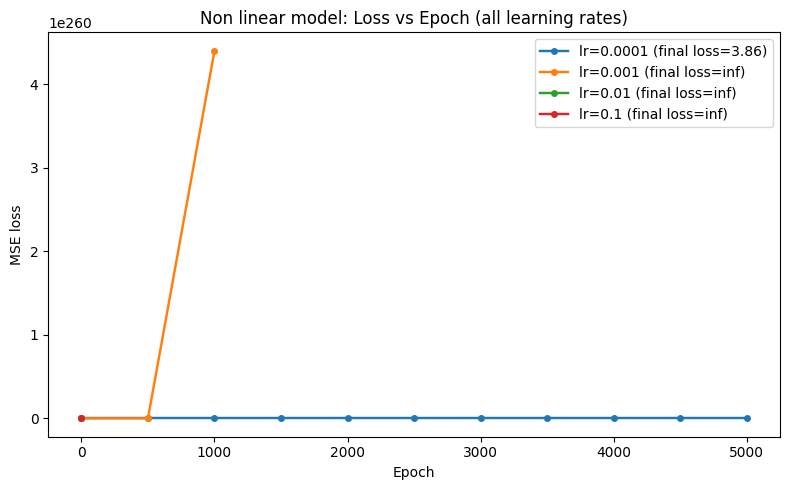

In [165]:
# Loss vs. Epoch plots (per model, all learning rates)
import numpy as np

def plot_loss_curves(title, run_dict):
    plt.figure(figsize=(8,5))
    for lr, rec in sorted(run_dict.items(), key=lambda kv: kv[0]):
        hist = rec["history"]
        if not hist:
            continue
        ep = np.array([h[0] for h in hist], dtype=float)
        ls = np.array([h[1] for h in hist], dtype=float)
        mask = np.isfinite(ls)
        ep = ep[mask]; ls = ls[mask]
        if len(ep) == 0:
            continue
        plt.plot(ep, ls, marker='o', linewidth=1.75, markersize=4,
                 label=f"lr={lr} (final loss={rec['final_loss']:.2f})")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_loss_curves("Linear model: Loss vs Epoch (all learning rates)", linear_runs)
plot_loss_curves("Non linear model: Loss vs Epoch (all learning rates)", quad_runs)
